# Table of Contents
 <p><div class="lev1"><a href="#Simulating-Data"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulating Data</a></div><div class="lev1"><a href="#Expectation-Propagation"><span class="toc-item-num">2&nbsp;&nbsp;</span>Expectation Propagation</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
$$

Many regression discontinuity examples we've seen are either point processes or have binary outcomes. They can still be modeled with a latent GP, but the likelihood will need to be Poisson or Binomial instead of Gaussian. This shouldn't be too difficult, but I want to make sure I understand how this works. I'll follow the classification chapter in Rasmussen&Williams (chapter 3), and try to build up to reproducing figure 3.6.

<img width=500 src="rasmussen_3_6.png"/>

# Simulating Data

In [1]:
using Distributions
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

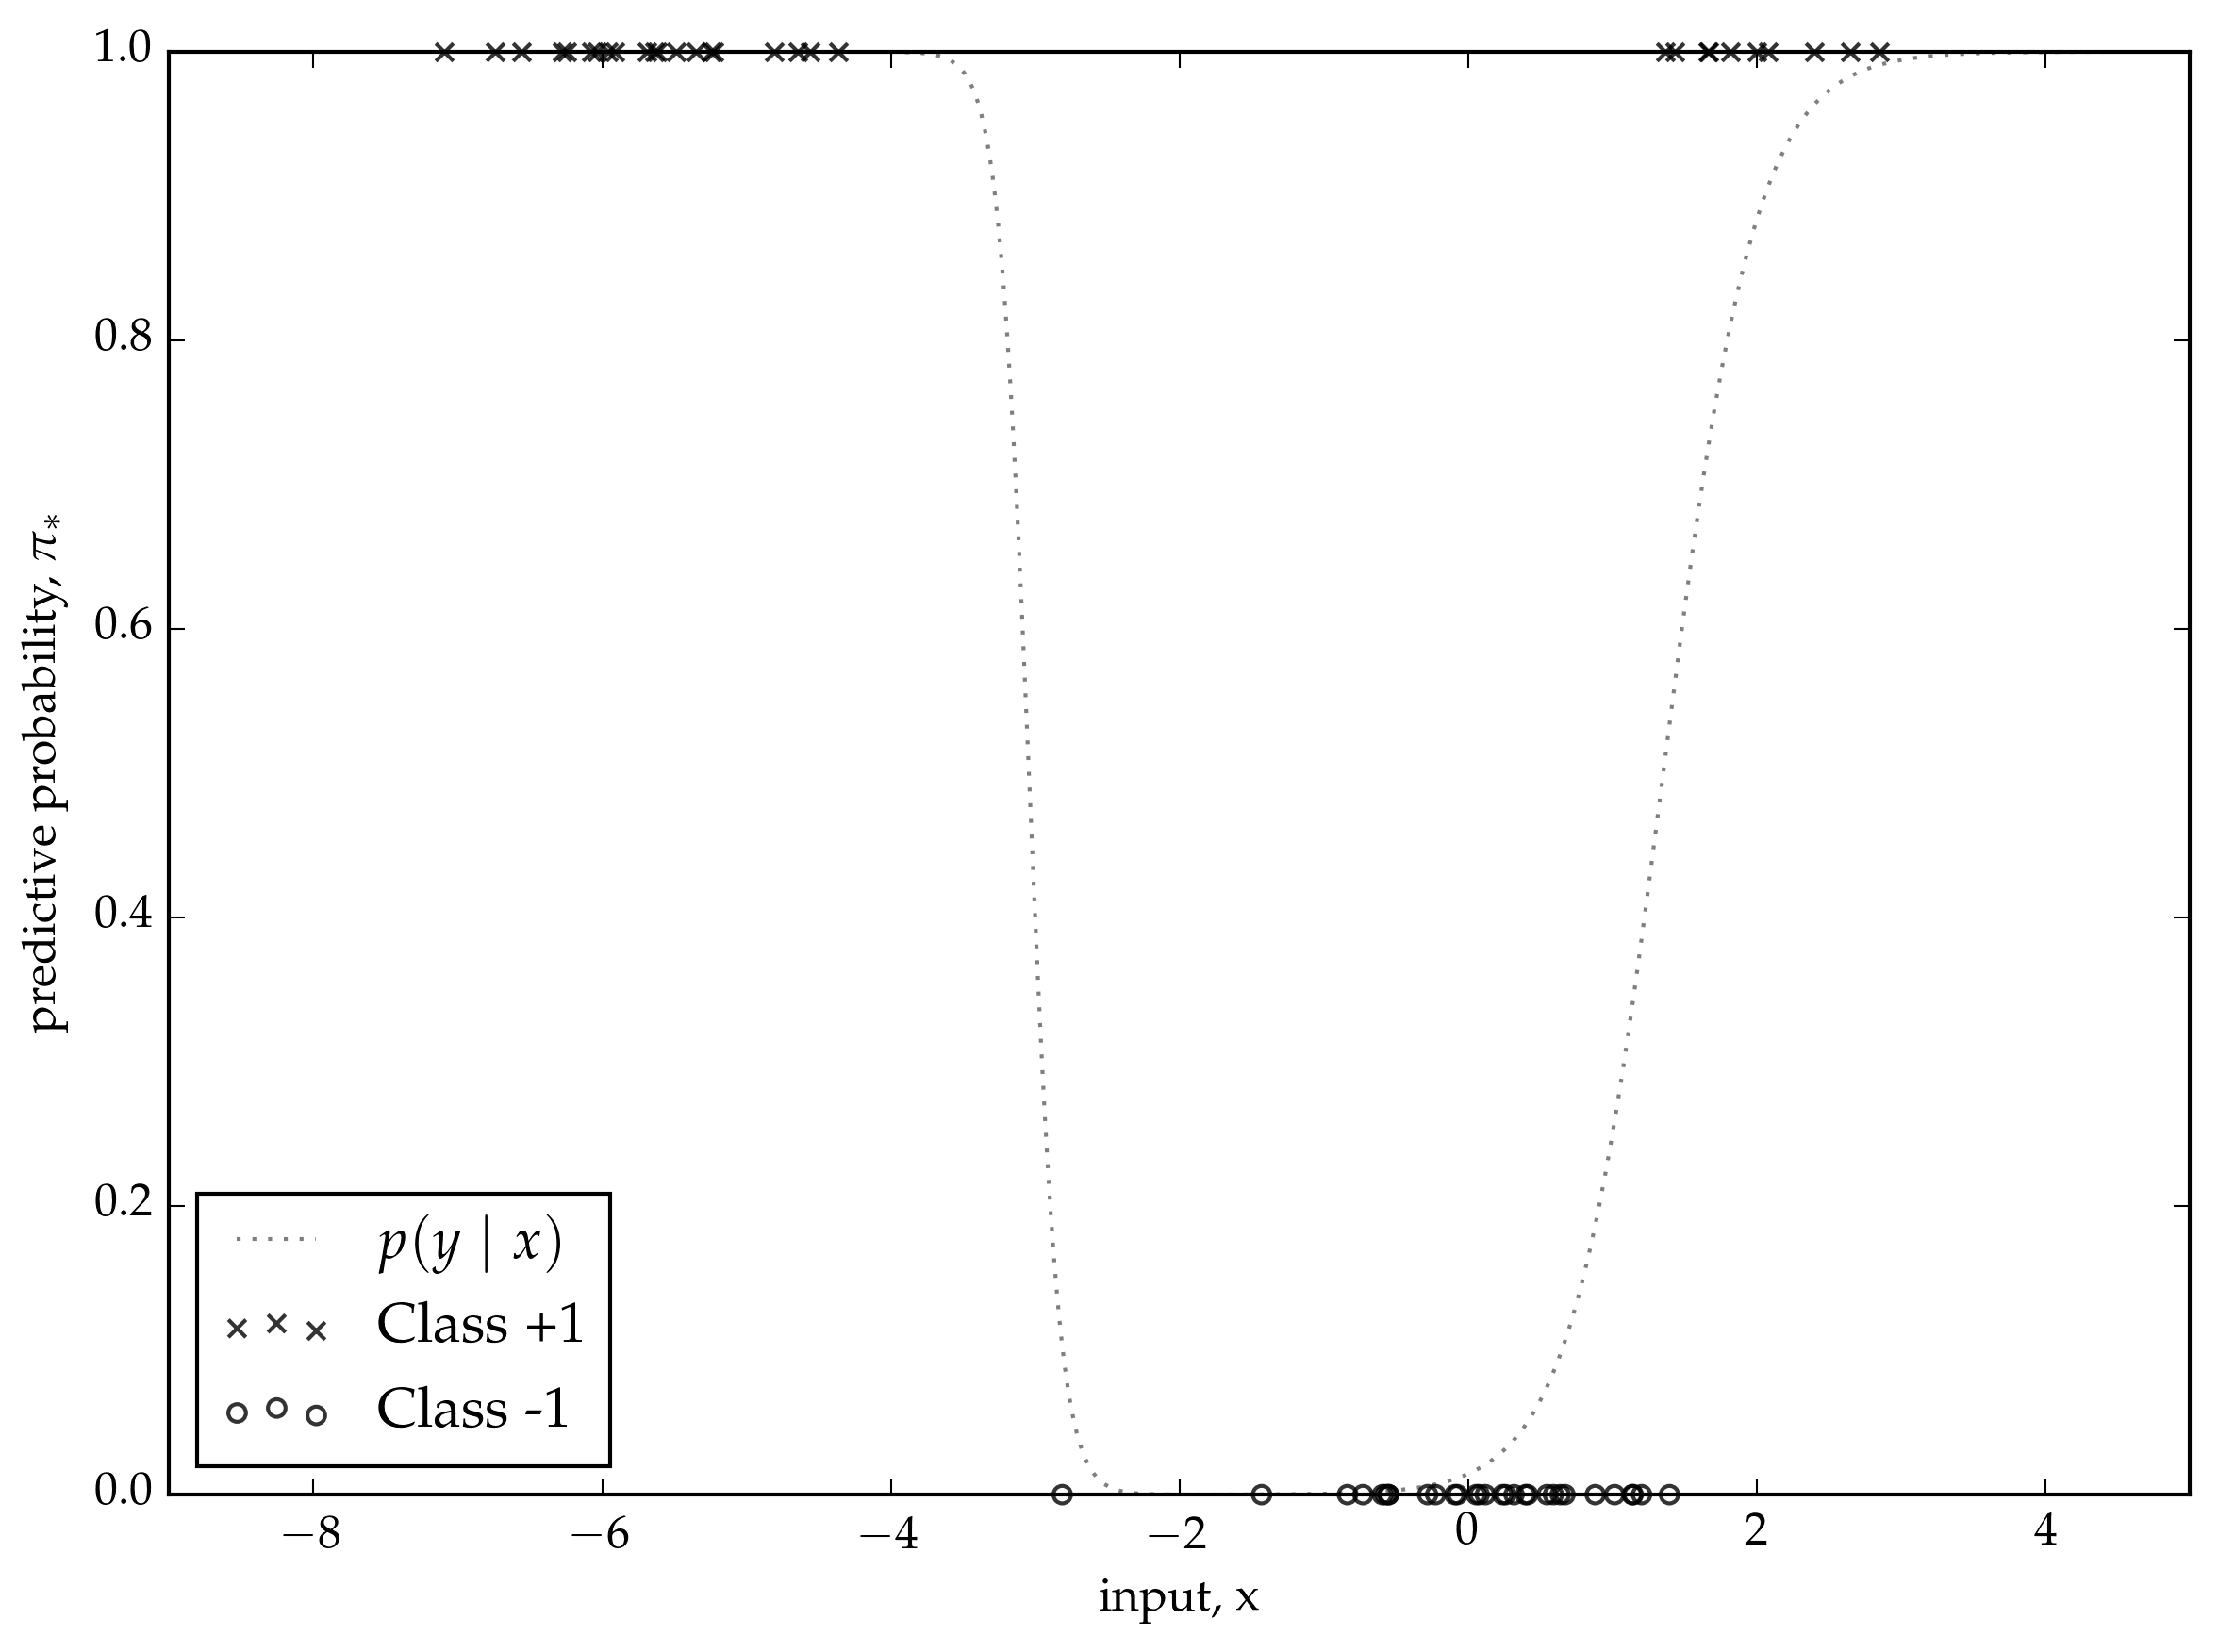

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [2]:
group_1 = Normal(-6.0, 0.8)
n1=20
group_2 = Normal(-0.0, 0.8)
n2=30
group_3 = Normal(2.0, 0.8)
n3=10
locations = [rand(group_1, n1); rand(group_2, n2); rand(group_3, n3)]
labels = [ones(Int, n1); -ones(Int, n2); ones(Int, n3)]
xx = linspace(-10,10,1000)
py = [(pdf(group_1,x)*n1+pdf(group_3,x)*n3)/(pdf(group_1,x)*n1+pdf(group_2,x)*n2+pdf(group_3,x)*n3) for x in xx]

plt.scatter(locations[1:n1], ones(n1), marker="x", color="black", alpha=0.8, label="Class +1", clip_on=false)
plt.scatter(locations[n1+1:n1+n2], zeros(n2), marker="o", color="none", edgecolor="black", alpha=0.8, label="Class -1", clip_on=false)
plt.scatter(locations[n1+n2+1:n1+n2+n3], ones(n3), marker="x", color="black", alpha=0.8, clip_on=false)
plt.plot(xx, py, linestyle=":", color="black", alpha=0.5, label=L"p(y \mid x)")
plt.legend(loc="lower left")
plt.xlabel("input, x")
plt.ylabel(L"predictive probability, $\pi_*$")
plt.xlim(-9, 5)
plt.ylim(0,1)
;

# Expectation Propagation

In [3]:
import GaussianProcesses
GP=GaussianProcesses

GaussianProcesses

In [4]:
kern=GP.SEIso(log(2.6), log(7.0))

Type: GaussianProcesses.SEIso, Params: [0.9555114450274365,1.9459101490553132]


In [5]:
n = n1+n2+n3
K = GP.crossKern(locations', kern)
y = labels
;

In [36]:
function μΣ_from_ντ!(νtilde, τtilde, K, Σ, μ)
    Stilde12 = sqrt(τtilde)
    L = chol(eye(n) + (Stilde12*Stilde12').*K)
    V = L' \ (repmat(Stilde12,1,n).*K)
    Σ[:,:] = K-V'V
    μ[:] = Σ*νtilde
    return
end
function μΣ_from_ντ(νtilde, τtilde, K)
    μ = Array(Float64, n)
    Σ = Array(Float64, (n,n))
    μΣ_from_ντ!(νtilde, τtilde, K, Σ, μ)
    return μ, Σ
end

function EP_probit(K::Matrix{Float64}, Y::Vector{Float64})
    # initialize
    Z = Normal()
    νtilde = zeros(Float64, n)
    τtilde = zeros(Float64, n)
    μ = zeros(Float64, n)
    Σ = copy(K)

    τ_prev = similar(τtilde)+1
    ν_prev = similar(νtilde)+1
    function converged(τprev, τtilde, νprev, νtilde)
        ν_converged = maximum(abs(νprev.-νtilde)) < 1e-10
        τ_converged = maximum(abs(τprev.-τtilde)) < 1e-10
        return ν_converged & τ_converged
    end
    j = 0
    while !converged(τ_prev, τtilde, ν_prev, νtilde)
        j += 1
#         @printf("%d;", j)
        τ_prev[:] = τtilde
        ν_prev[:] = νtilde
        for i in randperm(n)
            τi = 1/Σ[i,i]
            τcavity =  τi - τtilde[i] # remove precision of current term
            νcavity = μ[i]*τi - νtilde[i] # remove contribution of current term from mean

            μcavity = νcavity / τcavity
            σ2cavity = 1/τcavity
        #     zi = Y[i] * νcavity / √(τcavity^2+τcavity)
            zi = Y[i] * μcavity / √(1+σ2cavity)
            Φzi = cdf(Z,zi)
            𝒩zi = pdf(Z,zi)
            μhat = (μcavity 
                + (
                Y[i]*
                σ2cavity * 𝒩zi) 
                / (Φzi*sqrt(1+σ2cavity)))
            σ2hat = (σ2cavity 
                - σ2cavity^2 * 𝒩zi 
                / (Φzi*(1+σ2cavity)) 
                * (zi + 𝒩zi / Φzi)
                )
            @assert !isnan(μhat)
            @assert !isnan(σ2hat)

            Δτtilde = 1/σ2hat - τcavity - τtilde[i]
            τtilde[i] += Δτtilde
            νtilde[i] = μhat/σ2hat - νcavity

            si = Σ[:,i]
            Σ -=  (Δτtilde/(1 + Δτtilde*Σ[i,i])) .* (si*si')
            μ[:] = Σ*νtilde
        end
        μΣ_from_ντ!(νtilde, τtilde, K, Σ, μ)
    end
    return νtilde, τtilde
end

EP_probit (generic function with 1 method)

In [37]:
function μΣ_from_ντ!(νtilde, τtilde, K, Σ, μ)
    Stilde12 = sqrt(τtilde)
    L = chol(eye(n) + (Stilde12*Stilde12').*K)
    V = L' \ (repmat(Stilde12,1,n).*K) # should be L transpose?
    Σ[:,:] = K-V'V
    μ[:] = Σ*νtilde
    return
end

μΣ_from_ντ! (generic function with 1 method)

In [38]:
_νtilde, _τtilde = EP_probit(K, convert(Vector{Float64}, y))
_μ, _Σ = μΣ_from_ντ(_νtilde, _τtilde, K);

In [43]:
# μpredict = kstar*(K \ _μ)
Stilde12 = sqrt(_τtilde)
SKS = (Stilde12*Stilde12').*K
L = chol(eye(n) + SKS)
z = vec(diagm(Stilde12)*(L'\(L\(Stilde12.*(K*_νtilde)))))
πbarstar = Array(Float64, length(xx))
for (i,x) in enumerate(xx)
    kstar = GP.crossKern(locations', [x]', kern)
    fbarstar = dot(vec(kstar), _νtilde - z)
    v = vec(L\(Stilde12.*kstar)) # pretty inefficient
    # assumes stationary kernel:
    kstarstar = GP.kern(kern,0.0)
    Vfstar = max(kstarstar - dot(v,v), 1e-10)
    @assert Vfstar>0
    πbarstar[i] = cdf(Normal(), fbarstar/√(1+Vfstar))
end

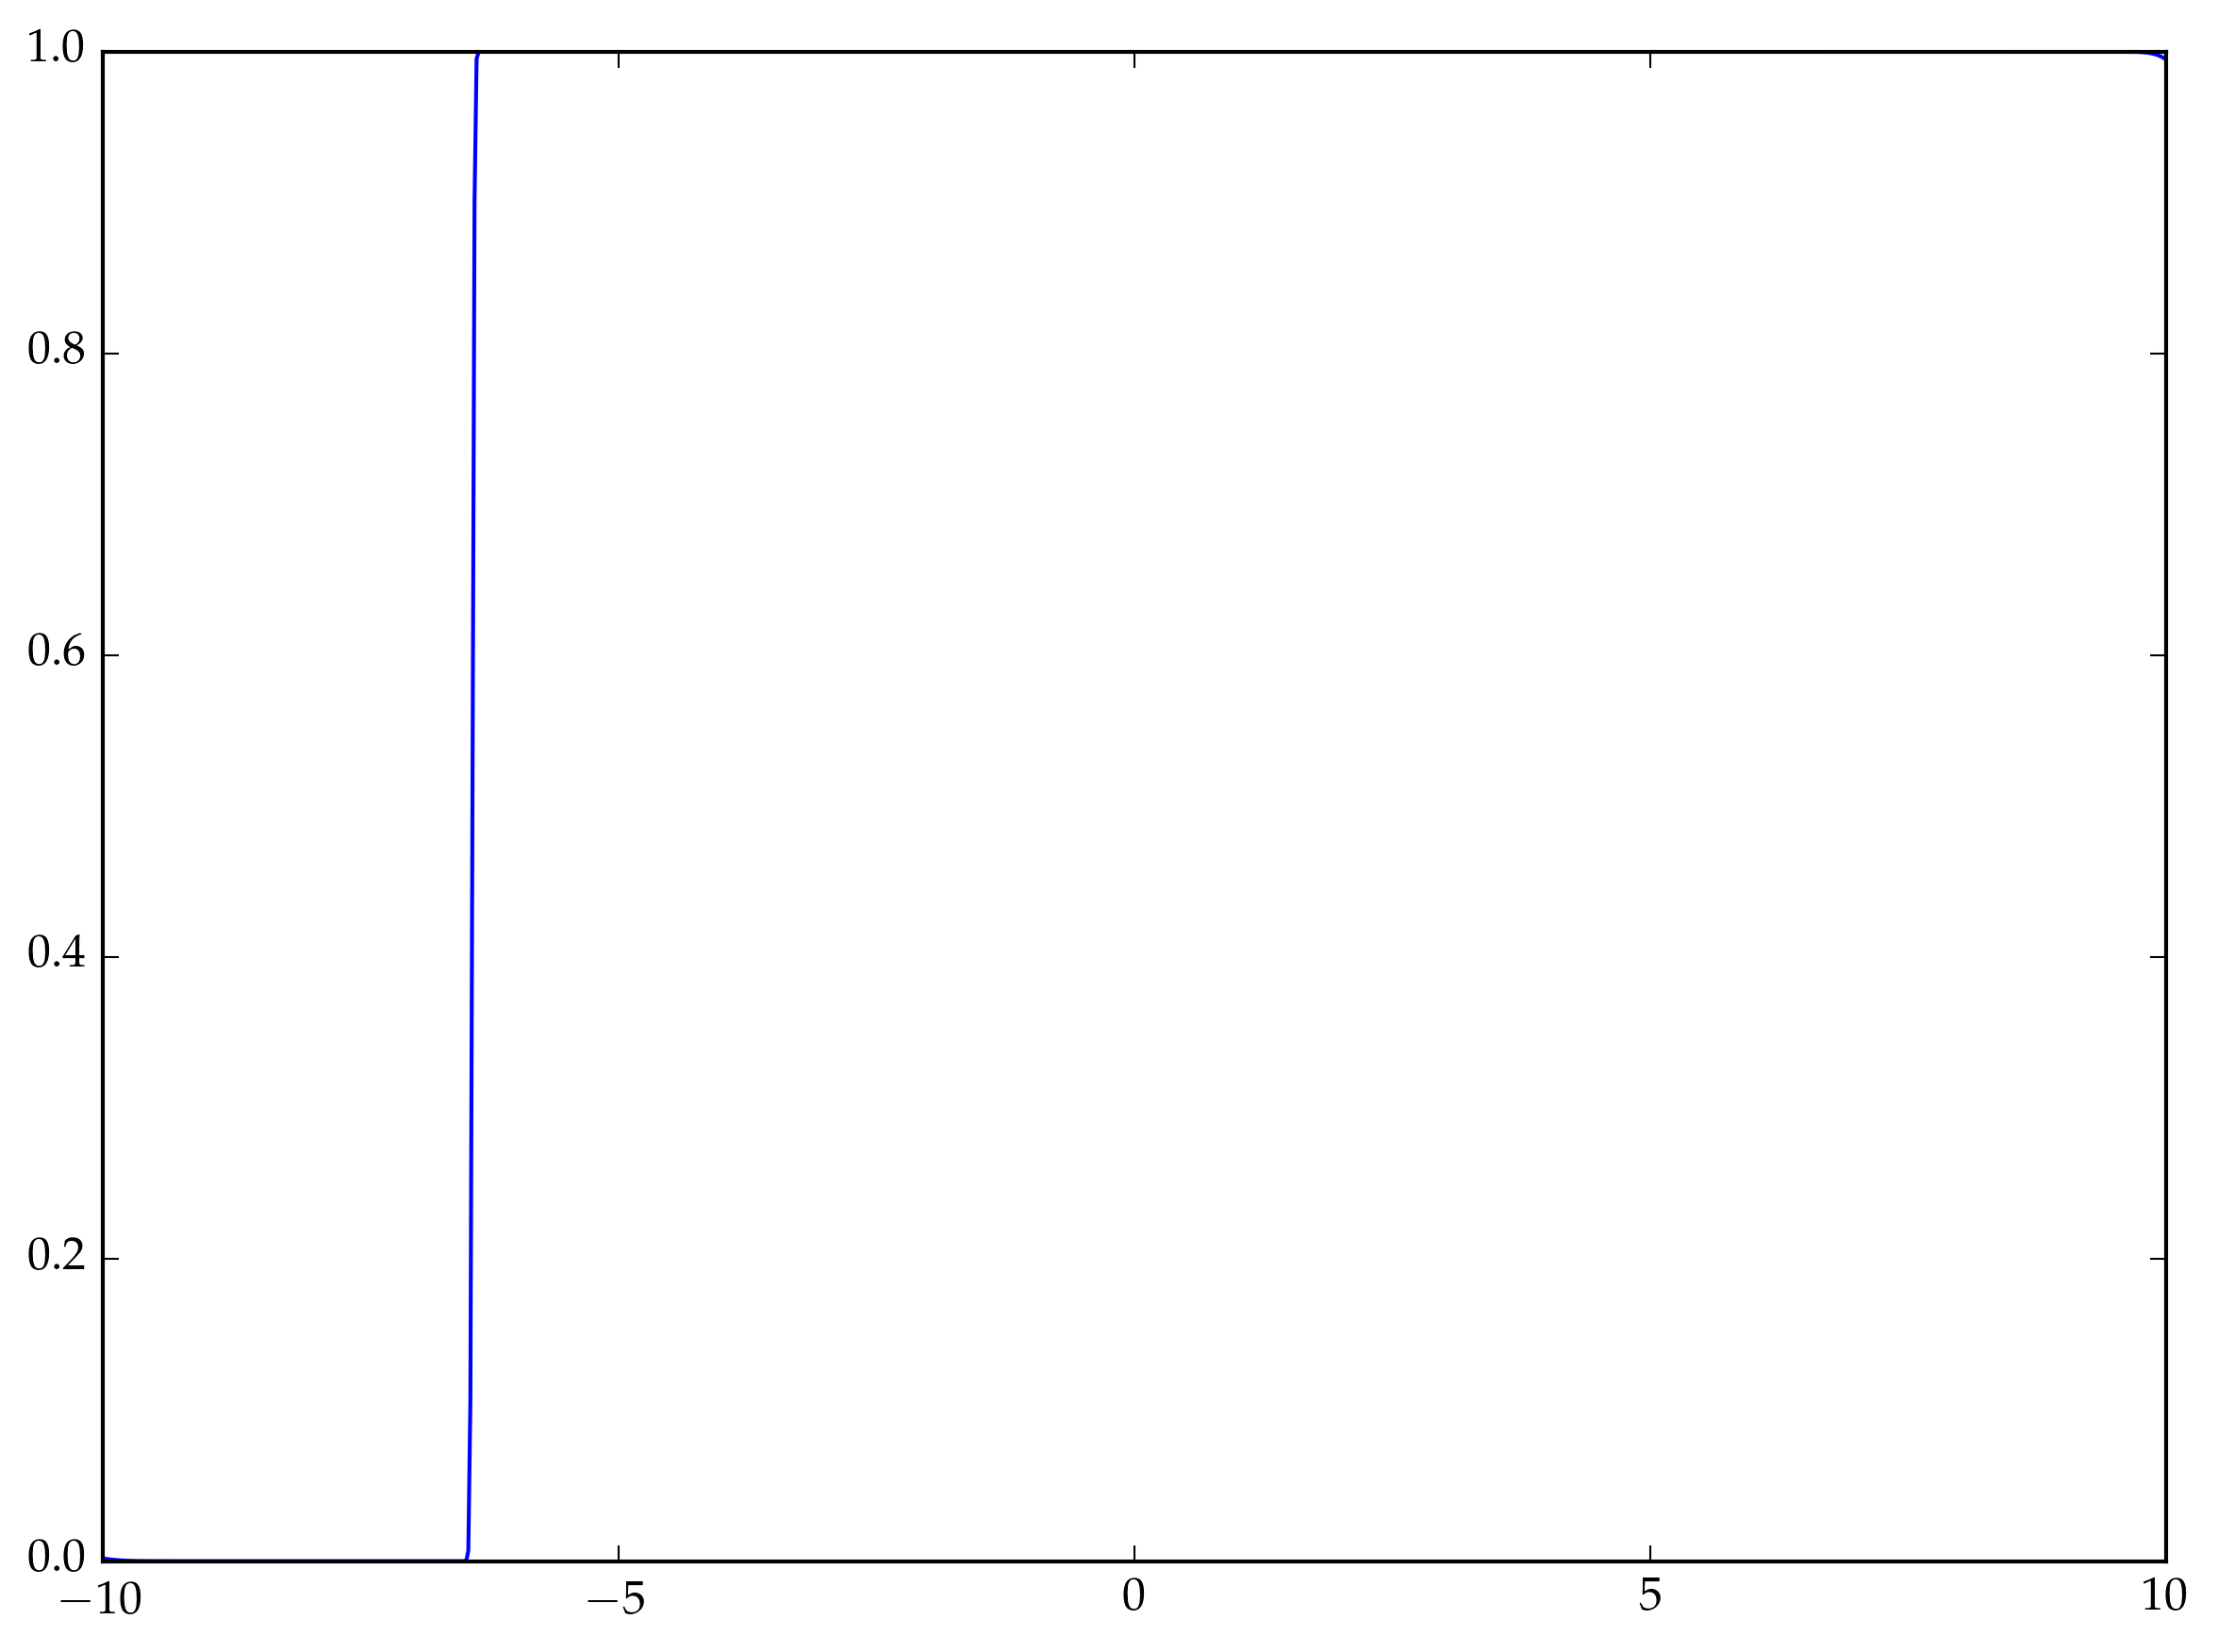

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324764350>

In [44]:
plt.plot(xx, πbarstar)

In [20]:
# μpredict = kstar*(K \ _μ)
πbarstar = Array(Float64, length(xx))
fbarstar = Array(Float64, length(xx))
Vfstar = Array(Float64, length(xx))
for (i,x) in enumerate(xx)
    kstar = vec(GP.crossKern(locations', [x]', kern))
    kstarstar = GP.kern(kern,0.0)
    Σtilde = diagm(1.0 ./ _τtilde)
    μtilde = (_νtilde./_τtilde)
    fbarstar[i] = dot(kstar, (K + Σtilde) \ μtilde)
    Vfstar[i] = kstarstar - dot(kstar, (K + Σtilde) \ kstar)
    # assumes stationary kernel:
    @assert Vfstar[i]>0
    πbarstar[i] = cdf(Normal(), fbarstar[i]/√(1+Vfstar[i]))
end

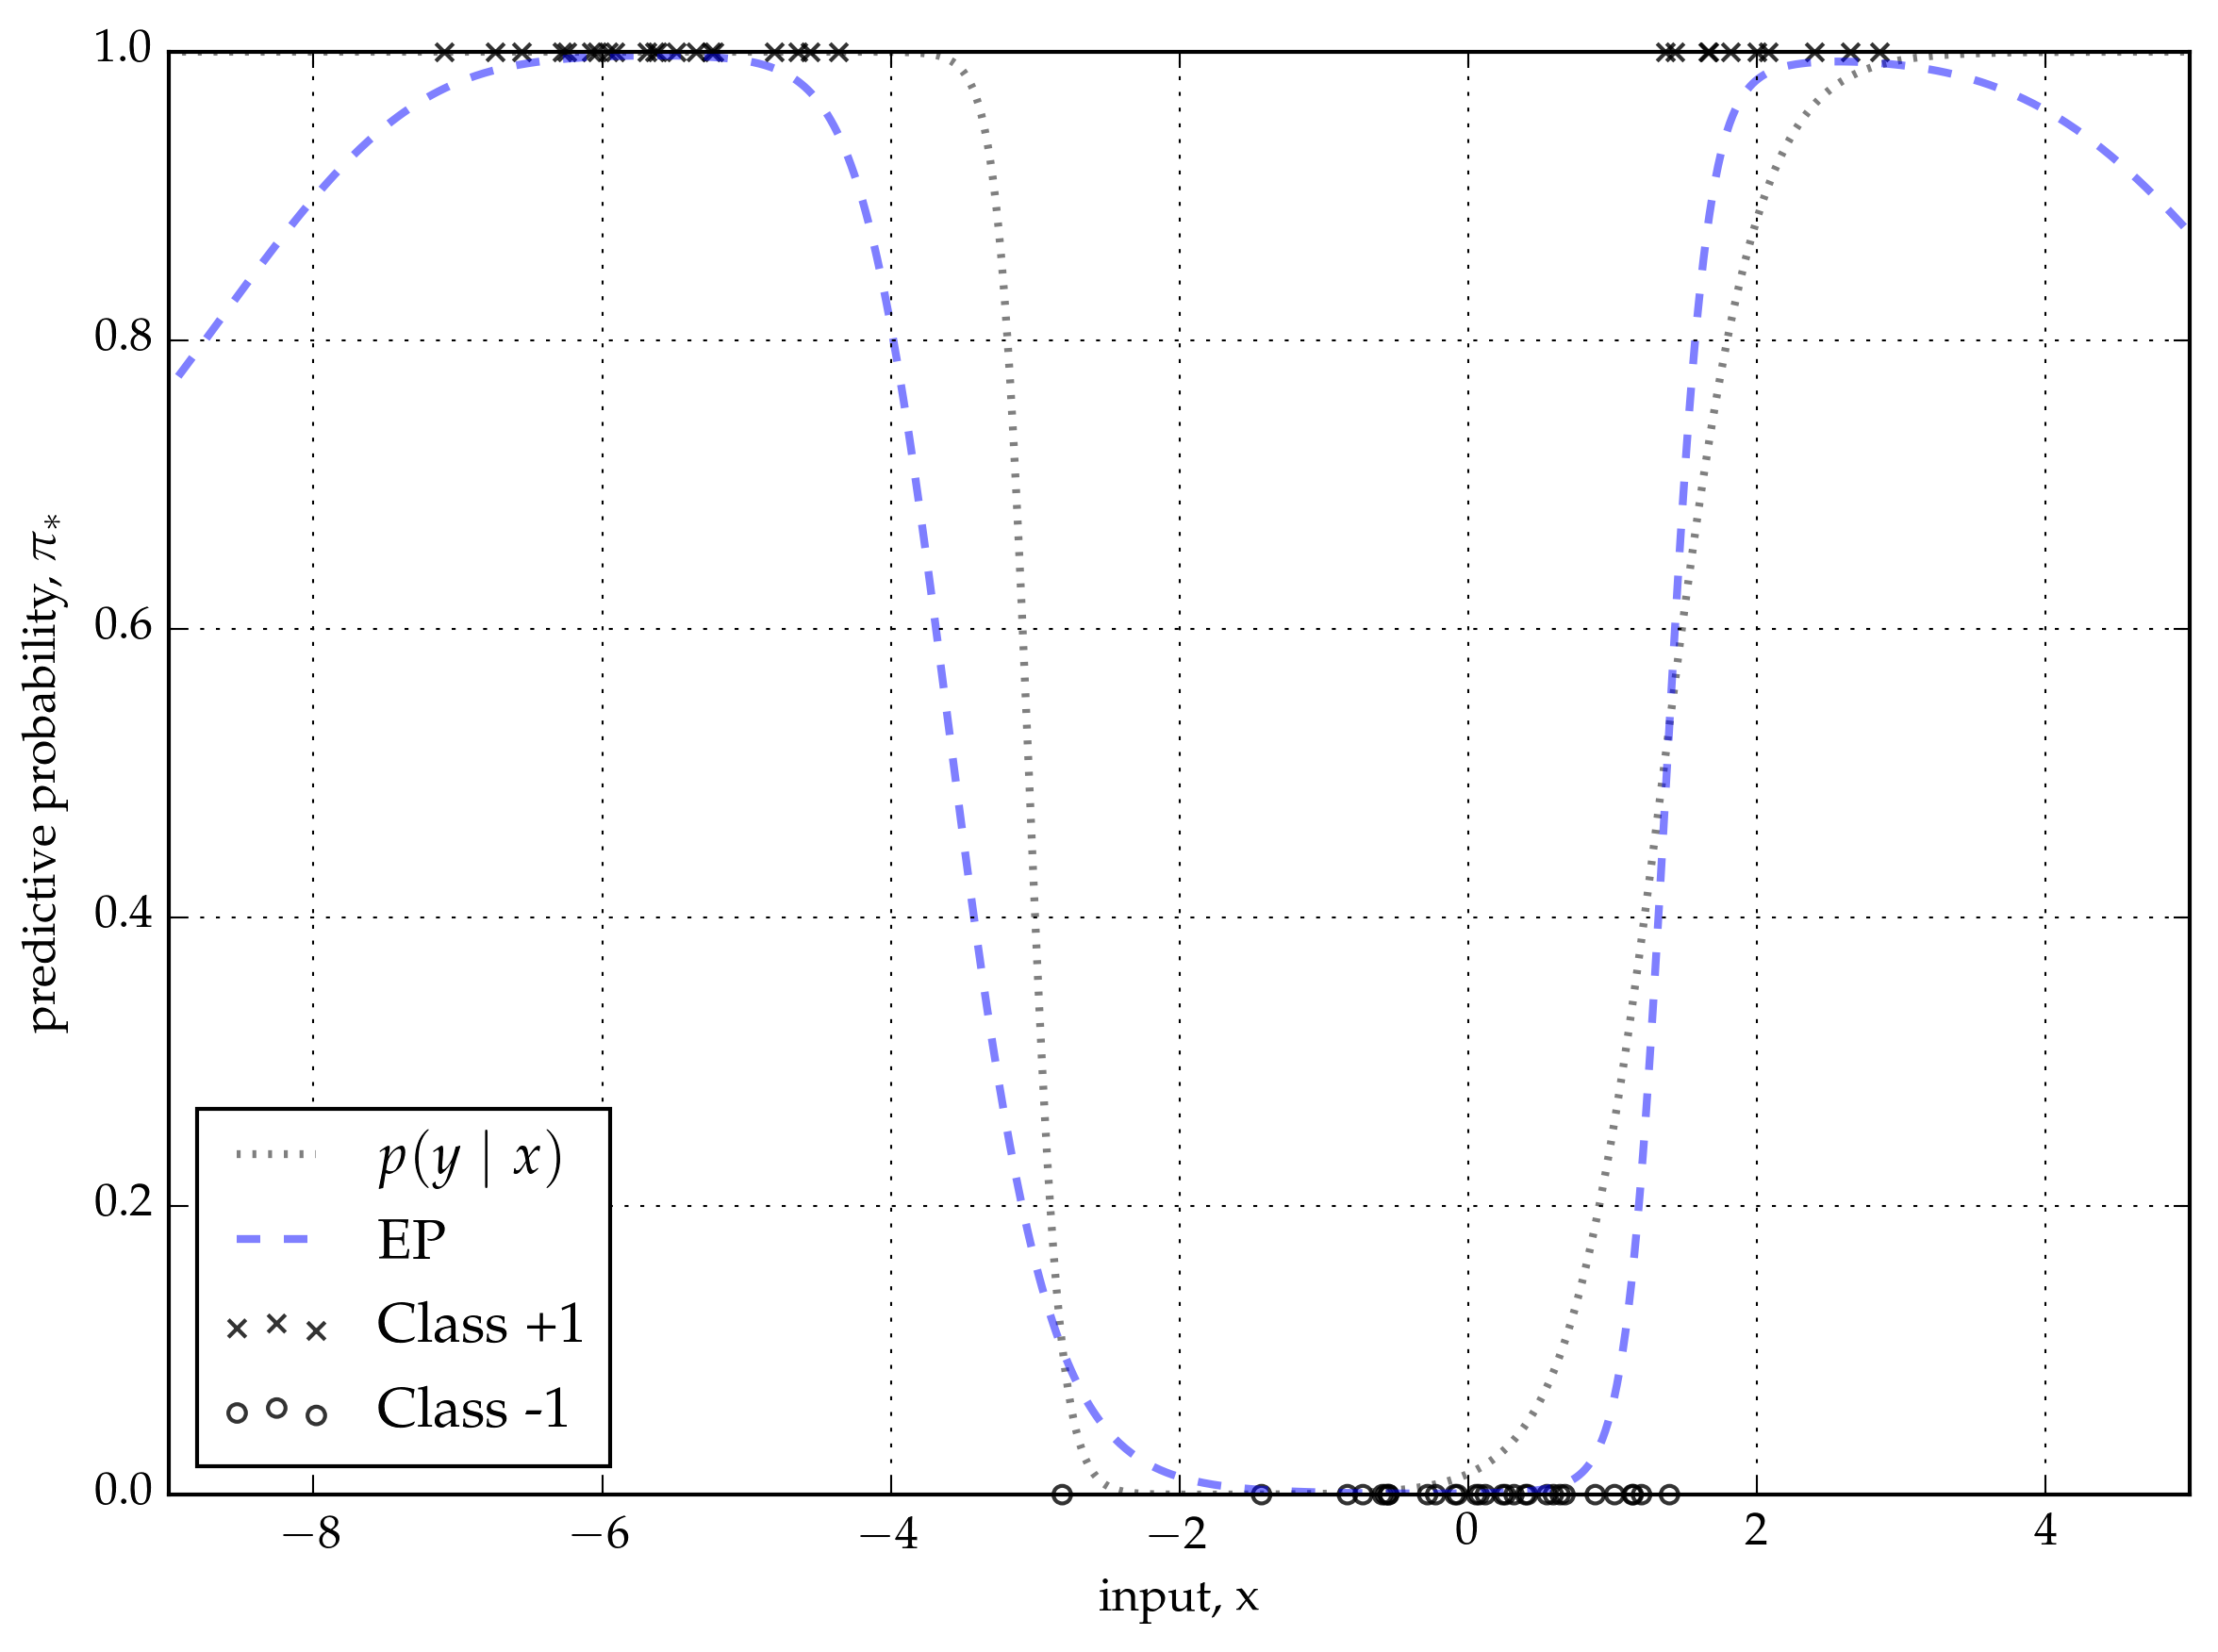

In [16]:
plt.scatter(locations[1:n1], ones(n1), marker="x", color="black", alpha=0.8, label="Class +1", clip_on=false)
plt.scatter(locations[n1+1:n1+n2], zeros(n2), marker="o", color="none", edgecolor="black", alpha=0.8, label="Class -1", clip_on=false)
plt.scatter(locations[n1+n2+1:n1+n2+n3], ones(n3), marker="x", color="black", alpha=0.8, clip_on=false)
plt.plot(xx, py, linestyle=":", color="black", alpha=0.5, label=L"p(y \mid x)", linewidth=2)
plt.plot(xx, πbarstar, linestyle="--", color="blue", alpha=0.5, label="EP", linewidth=2)
plt.legend(loc="lower left")
plt.xlabel("input, x")
plt.ylabel(L"predictive probability, $\pi_*$")
plt.xlim(-9, 5)
plt.ylim(0.0,1.0)
plt.grid()
;

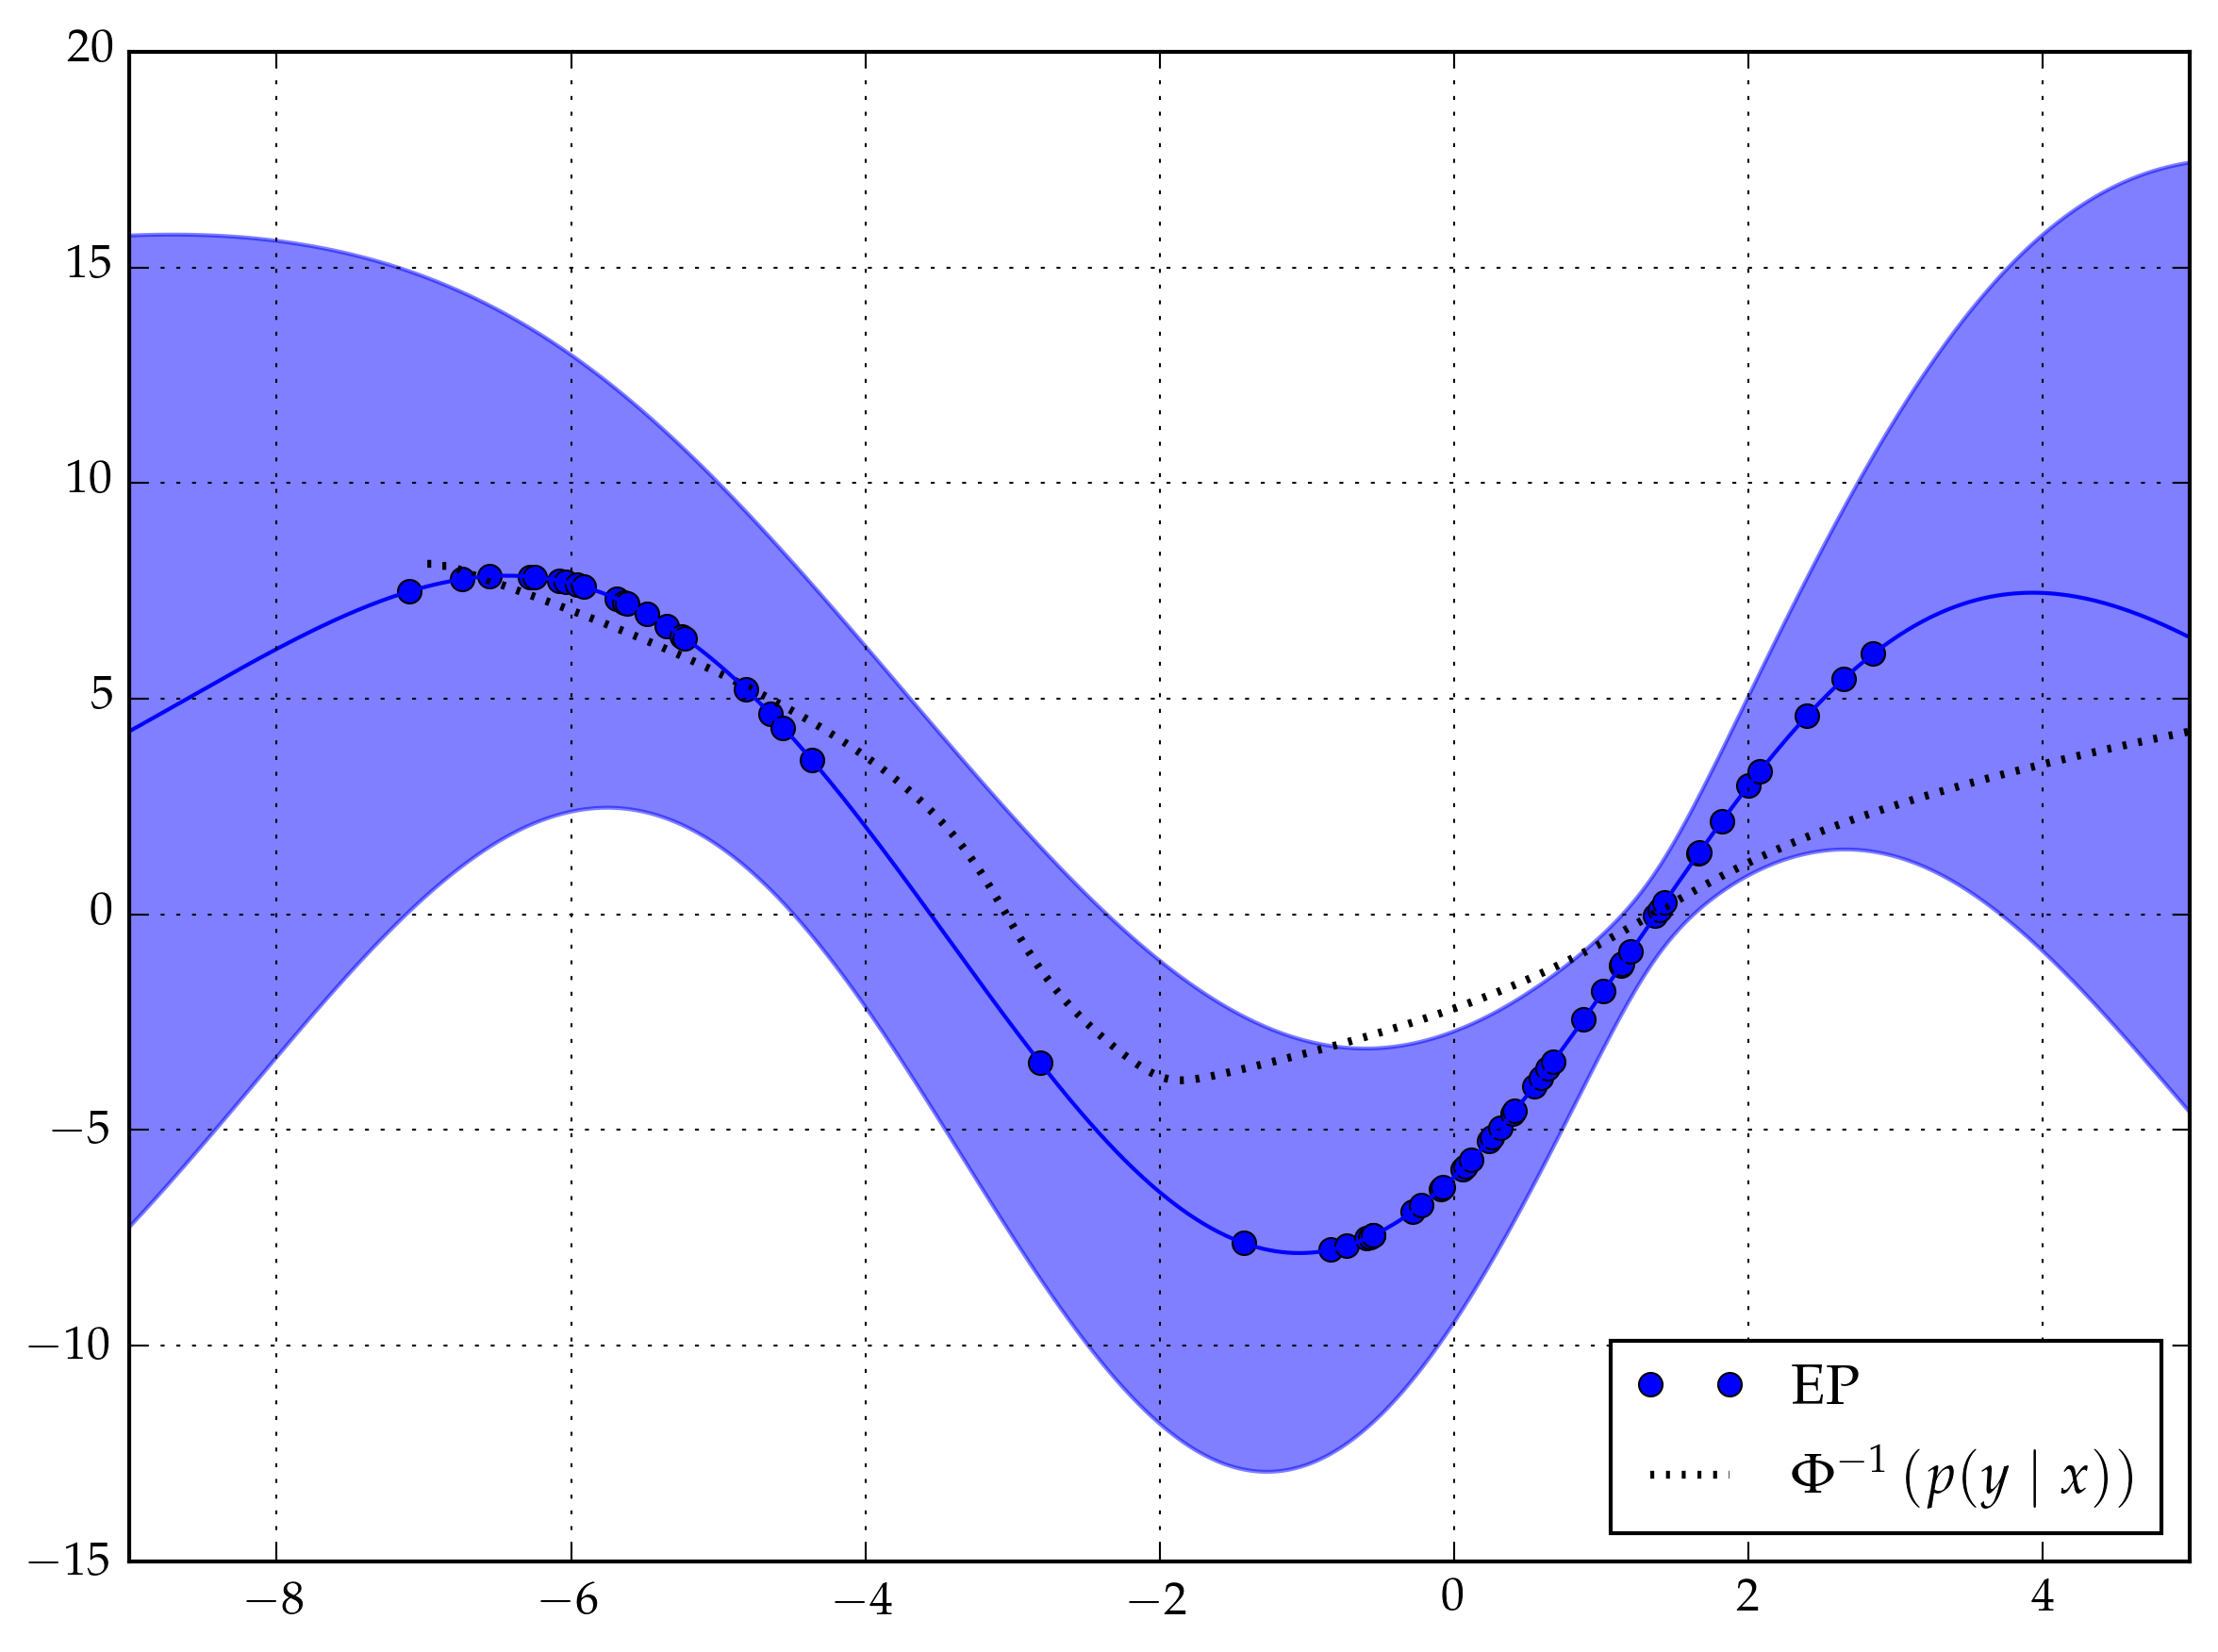

In [32]:
loc_order=sortperm(locations)
plt.plot(locations[loc_order],_μ[loc_order],"o", color="blue", label="EP")
plt.plot(xx, quantile(Normal(), py), color="black", linestyle=":", linewidth=2, label=L"$\Phi^{-1}\left(p(y \mid x)\right)$")
plt.plot(xx, fbarstar, color="blue", linestyle="-")
plt.fill_between(xx,fbarstar.-(2*sqrt(Vfstar)),fbarstar.+(2*sqrt(Vfstar)), 
    color="blue", 
    edgecolor="blue", 
    alpha=0.5)
plt.xlim(-9, 5)
plt.grid()
plt.legend(loc="lower right")
;